
# Prerequisite [10 Marks]
* Load required packages and load images (already uploaded on Blackboard) in Colab
* Create your own copy of notebook and add required code snippets in between the questions subsections. Also display the figures at each stage.
*Submit the lab on Blackboard by Feb 19, 2024 in **.ipynb** format.
*Colab can be exported as a notebook file or Python file by **File > Download .ipynb** or **File > Download .py**. Exported notebook files can be reloaded into Google Colab or used in Jupyter Notebook.
* Please go through [Colab document](https://colab.research.google.com/drive/1YKHHLSlG-B9Ez2-zf-YFxXTVgfC_Aqtt) for further information.

* **Use ONLY following basic tensorflow and numpy functions for any type of  operations**



In [90]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt


#A) Load Image 'xray_circuit.jpg'



Original Data_type is uint8
Data_type is uint8
Image Size is (495, 447, 1)
Image min and max are (0, 255)


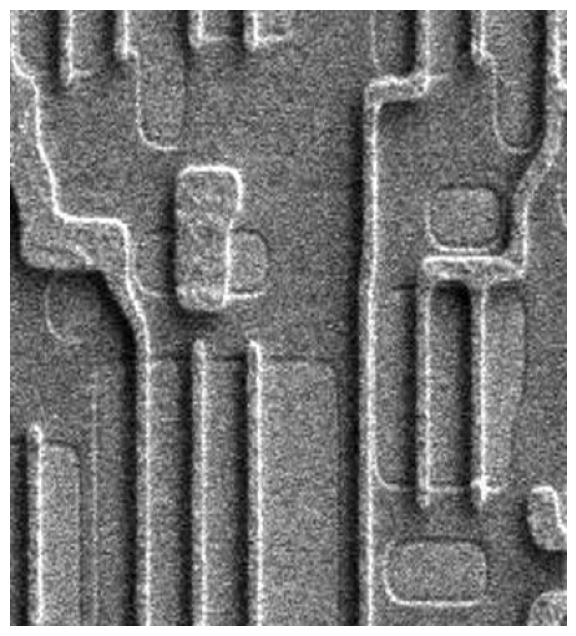

In [91]:
img_path = '/content/xray_circuit.jpg'
img =  tf.io.read_file(img_path)
img_a = tf.io.decode_jpeg(img)
img_a = tf.image.rgb_to_grayscale(img_a).numpy()
print('Original Data_type is {}'.format(img_a.dtype))
print('Data_type is', img_a.dtype)
print('Image Size is {}'.format(img_a.shape))
print('Image min and max are ({}, {})'.format(img_a.min(),img_a.max()))
#################################################
plt.figure(figsize=(8,8))
plt.imshow(img_a, cmap='gray')
plt.axis('off')
plt.show()

#B) Apply Isotropic Diffusion using 5x5 gaussian filter by applying it 10 times

In [92]:
frange = np.arange(-2,3)
[X,Y] = np.meshgrid(frange,frange,indexing='ij')
filter = np.exp(-(X**2+Y**2)/2)
fsum = filter.ravel().sum()
filter /= fsum

In [93]:
filter,filter.ravel().sum()

(array([[0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902],
        [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
        [0.02193823, 0.09832033, 0.16210282, 0.09832033, 0.02193823],
        [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
        [0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902]]),
 1.0)

In [94]:
img_a.shape

(495, 447, 1)

In [95]:
gauss_filter = tf.constant(filter, shape=(5, 5, 1, 1))
img_a1 = tf.constant(img_a, shape=(1,img_a.shape[0], \
                                   img_a.shape[1], img_a.shape[2]))
img_a1 = tf.cast(img_a1, tf.float64)
img_b = img_a1
for i in range(10):
  img_b = tf.nn.conv2d(img_b, gauss_filter, \
                       strides=[1, 1, 1, 1], padding='SAME')


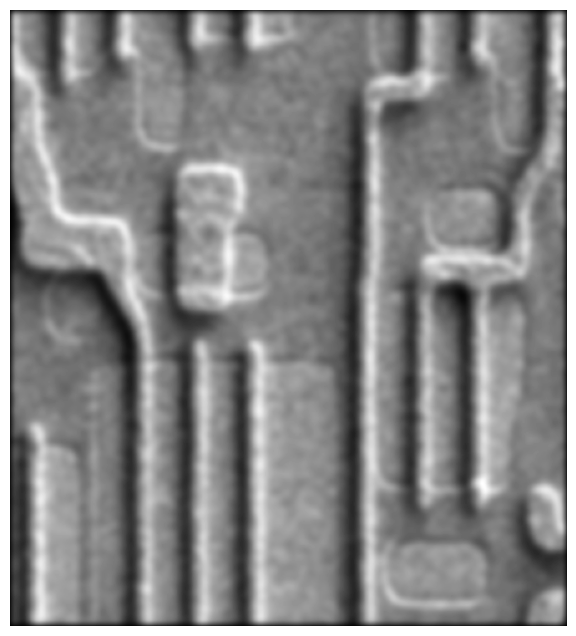

In [96]:
plt.figure(figsize=(8,8))
plt.imshow(img_b.numpy().astype(np.uint8).squeeze(), cmap='gray')
plt.axis('off')
plt.show()

In [97]:
img_b.shape

TensorShape([1, 495, 447, 1])

#C) Apply Non-linear Isotropic Diffusion using 5x5 thresholded gaussian filter [5 Marks]

In [98]:
#
frange = np.arange(-2,3)
[X,Y] = np.meshgrid(frange,frange, indexing='ij')
filter = np.exp(-(X**2 + Y**2)/2)
filter /= filter.ravel().sum()

In [99]:
filter,filter.ravel().sum()

(array([[0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902],
        [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
        [0.02193823, 0.09832033, 0.16210282, 0.09832033, 0.02193823],
        [0.01330621, 0.0596343 , 0.09832033, 0.0596343 , 0.01330621],
        [0.00296902, 0.01330621, 0.02193823, 0.01330621, 0.00296902]]),
 1.0)

In [100]:
gauss_filter = tf.constant(filter, shape=(5, 5, 1, 1))

# Filter to measure dI/dx
dx_kernel = tf.convert_to_tensor([-1, 0, 1])
dx_kernel = tf.reshape(dx_kernel, (3, 1, 1, 1))
dx_kernel = tf.cast(dx_kernel, tf.float64)

# Filter to measure dI/dy
dy_kernel = tf.convert_to_tensor([-1, 0, 1])
dy_kernel = tf.reshape(dy_kernel, (1, 3, 1, 1))
dy_kernel = tf.cast(dy_kernel, tf.float64)

# Looping over iterations
img_b1 = img_a1
for i in range(10):
    x_derivative = tf.nn.conv2d(img_b1, dx_kernel, strides=[1, 1, 1, 1], padding="SAME")
    y_derivative = tf.nn.conv2d(img_b1, dy_kernel, strides=[1, 1, 1, 1], padding="SAME")

    # Filter to measure |dI/dx| + |dI/dy| = gradient
    gradient = tf.abs(x_derivative) + tf.abs(y_derivative)

    # Filter to measure (|dI/dx| + |dI/dy|)^2]
    gradient_squared = tf.multiply(gradient, gradient)

    # Get tensor object of k^2
    k = 34
    k_squared = tf.convert_to_tensor(k ** 2)
    k_squared = tf.cast(k_squared, tf.float64)

    # Filter to measure (|dI/dx| + |dI/dy|)^2/k^2
    normalized_gradient_squared = gradient_squared / k_squared

    # Filter to measure e^(-((|dI/dx| + |dI/dy|)^2/k^2))
    filter_output = tf.exp(-normalized_gradient_squared)

    # Multiply filter output to the Image be it numerator
    numerator = tf.multiply(filter_output, img_b1)

    # Apply same gaussian filter to numerator
    numerator = tf.nn.conv2d(numerator, gauss_filter, strides=[1, 1, 1, 1], padding="SAME")

    # Let e^(-((|dI/dx| + |dI/dy|)^2/k^2)) be denominator
    # Apply same gaussian filter to denominator
    denominator = tf.exp(-normalized_gradient_squared)
    denominator = tf.nn.conv2d(denominator, gauss_filter, strides=[1, 1, 1, 1], padding="SAME")

    # Let replace filer output with numerator/denominator
    img_b1 = numerator / denominator

Data_type is float64
Image Size is (495, 447)
Image min and max are (8.234702776652995, 252.25423998611794)


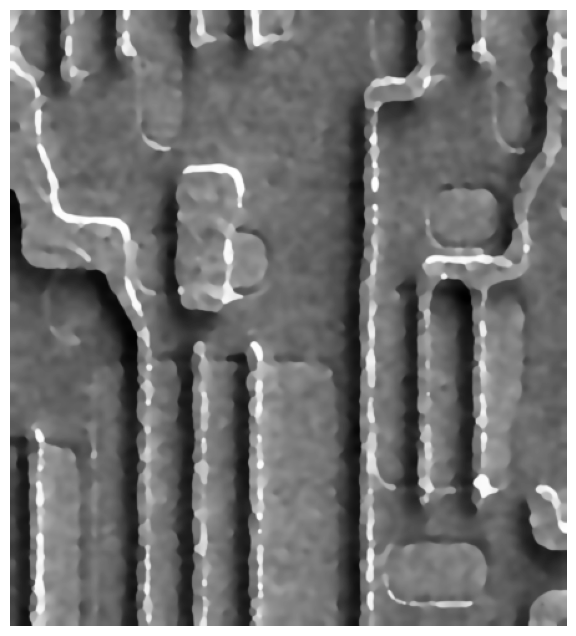

In [101]:
img_b11 = img_b1.numpy().squeeze()
print('Data_type is', img_b11.dtype)
print('Image Size is {}'.format(img_b11.shape))
print('Image min and max are ({}, {})'.format(img_b11.min(),img_b11.max()))

plt.figure(figsize=(8,8))
plt.imshow(img_b11.astype(np.uint8), cmap='gray')
plt.axis('off')
plt.show()

#D) Implement Anisotropic diffusion [5 Marks]

Initialize Variables


In [102]:
a_min=img_a.min()
a_max=img_a.max()

niter = 100 # number of gradient descent iteration.
option = 2 # 1 Perona Malik diffusion equation No 1
           # 2 Perona Malik diffusion equation No 2
kappa = 8  #8 # conductance coeefficient
step = (1,1)
lambDA = 0.15

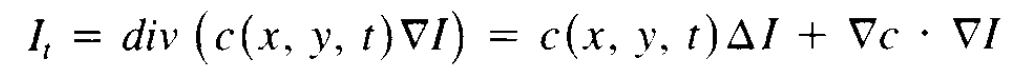
Option-1--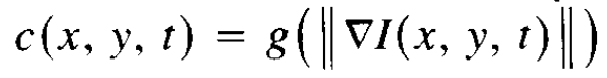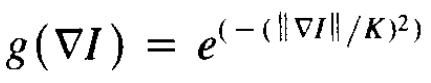

Option-2--
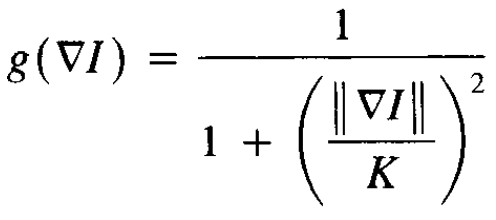

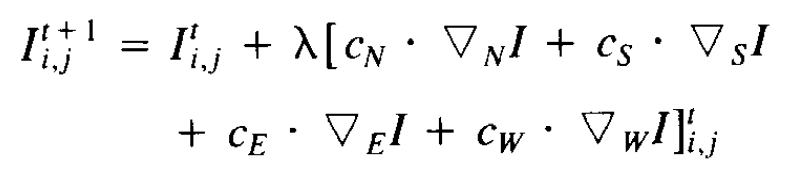

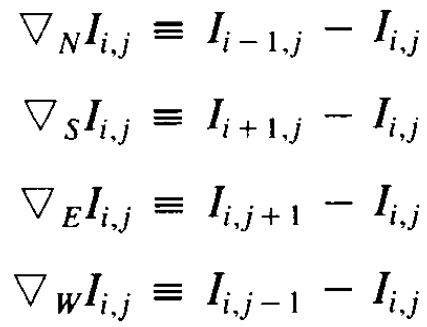
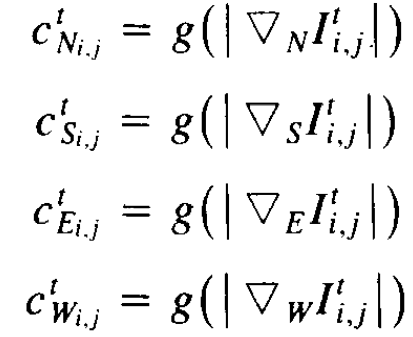

In [103]:
def g(option: int, nabla_i: tf.Tensor) -> np.ndarray:
    if option == 1:
        return np.exp(-((nabla_i / kappa) ** 2))
    elif option == 2:
        return 1 / (1 + ((nabla_i / kappa) ** 2))


imgout = img_a.copy().astype(np.float32)

for i in range(niter):
    grad_n = np.roll(imgout, -1, axis=0) - imgout
    grad_s = np.roll(imgout, 1, axis=0) - imgout
    grad_w = np.roll(imgout, 1, axis=1) - imgout
    grad_e = np.roll(imgout, -1, axis=1) - imgout

    imgout += lambDA * (grad_n * g(option, grad_n) + grad_s * g(option, grad_s) + grad_w * g(option, grad_w) + grad_e * g(option, grad_e))

ImageOut min and max are (20.644989013671875, 230.45310974121094)
Img_c1 min and max are (0.0, 1.0)
Data_type is uint8
Image Size is (495, 447, 1)
Image min and max are (0, 255)


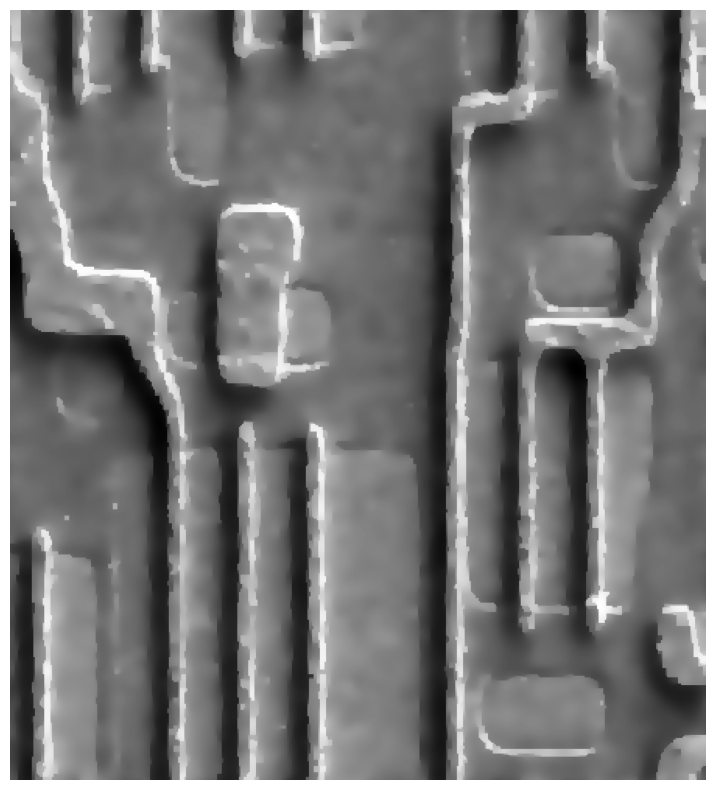

In [104]:
#imageout is output of Anisotropic diffusion process
print('ImageOut min and max are ({}, {})'.format(imgout.min(),imgout.max()))
img_c1 = (imgout - imgout.min())/(imgout.max()-imgout.min())
print('Img_c1 min and max are ({}, {})'.format(img_c1.min(),img_c1.max()))
img_c = img_c1*(a_max-a_min) + a_min
img_c = img_c.astype(np.uint8)
print('Data_type is', img_c.dtype)
print('Image Size is {}'.format(img_c.shape))
print('Image min and max are ({}, {})'.format(img_c.min(),img_c.max()))
#################################################
plt.figure(figsize=(10,10))
plt.imshow(img_c, cmap='gray')
plt.axis('off')
plt.show()